### About this document
This is the task assigned for the UCL CASA course, Data Science for Spatial Systems (CASA0006).
This Jupyter notebook is self-sufficient, containing an organized introduction, detailed discussion, embedded code, and references.

Find the code [at this location](https://github.com/jianhongliu99/CASA0006/blob/main/Traffic_Flow_Forecast.ipynb) <br/>

Access the data [through this link](https://github.com/jianhongliu99/CASA0006/blob/main/road.csv) <br/>


# "A Comparative Study: Traffic Flow Forecasting Using LSTM vs LSTM with GCN"

**Author:** JIANHONG LIU<br>
**Description:** This article evaluates the effectiveness of Long Short-Term Memory (LSTM) versus Long Short-Term Memory with Graph Convolutional Networks (LSTM+GCN) in forecasting traffic movement.

## **Abstract**:

This study aims to compare the performance of Long Short-Term Memory (LSTM) and LSTM combined with Graph Convolutional Network (GCN) in traffic flow forecasting. Traffic flow forecasting is a critical task in intelligent transportation systems and holds significant value for traffic management and planning. However, due to the complexity and uncertainty of traffic flow, accurate prediction remains a challenge.

In this research, we did not introduce a new forecasting model but opted to compare two existing forecasting methods: one using LSTM alone and the other integrating LSTM with GCN. Our experiments were conducted on a public traffic dataset from Xi'an and were evaluated using common prediction accuracy metrics.

The experimental results demonstrate that the LSTM combined with GCN significantly outperforms the model that uses LSTM alone in terms of prediction accuracy. This suggests that, even though we did not propose a new forecasting model, our comparative analysis indicates that the integration of LSTM and GCN can effectively enhance the accuracy of traffic flow prediction.

Therefore, our research underscores that comparative analysis is an effective research method that can assist in identifying superior traffic flow prediction models. This offers fresh perspectives and tools for future traffic flow forecasting studies.

**Keywords: LSTM, GCN, Traffic Flow Forecasting, Comparative Study**

## 1.0 | Introduction
Accurate and real-time traffic flow forecasting is crucial in Intelligent Transportation Systems (ITS), especially for traffic control. Existing models such as ARMA, and ARIMA are primarily linear models, which fail to capture the randomness and non-linearity of traffic flow, resulting in low prediction accuracy.

In recent years, deep learning methods have been proposed as a new option for traffic flow prediction. This paper demonstrates how to use Graph Neural Networks and LSTM to predict traffic conditions. Specifically, Our research focus centers on the precise forecast of forthcoming traffic speed values, utilizing the historical data pertaining to a collection of road segments.

One approach to address this problem is to treat the traffic speed of each road segment as an individual time series and use past values from the same time series to predict future values of each time series. 

However, this approach fails to account for the influence of one road segment's speed on the speeds of its neighboring segments. To address the intricate interactions among traffic speeds within a network of adjacent roads, we can conceptualize the traffic network as a graph and interpret the traffic speed as a signal propagating on this graph. In this study, we do not introduce a novel model but rather implement and compare two established neural network architectures capable of handling temporal data series on graphs.

Primarily, we illustrate the data processing methodology and the construction of a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), followed by the implementation of an LSTM-based model for the prediction of traffic flow. Subsequently, we develop a composite model that incorporates graph convolutional layers alongside LSTM to forecast traffic patterns on the graph. The primary emphasis of this paper lies in the comparative analysis of the efficacy of these two models in traffic flow prediction..

### 1.1 | Requirements to run the analysis

In [2]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 36.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 43.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.8/181.8 kB 2

In [3]:
#Import required libraries
import pandas as pd
import numpy as np
import os
import typing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


2023-09-05 04:59:39.373673: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 04:59:39.606953: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 04:59:39.607991: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 04:59:40.472254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 2.0 | Literature review

### Literature

Up-to-date and precise traffic data is sought after by commuters, businesses, and governmental bodies (N. Zhang et al., 2018). This information can guide road users towards smarter travel choices and elevate the efficiency of traffic management. Consequently, there has been a growing interest in predicting traffic flow, especially with the swift progression and implementation of intelligent transportation systems (ITS).

Early models for predicting traffic flow relied on techniques such as the Autoregressive Integrated Moving Average (ARIMA) model, introduced in the 1970s to project short-term road traffic patterns (Ahmed and Cook, 1979). As the years progressed, experts spanning domains like transportation engineering, statistics, machine learning, control systems, and economics put forth a variety of predictive models. Broadly, these models fall into three primary classifications: parameter-based methodologies, non-parameterized techniques, and simulation-driven strategies. Time series models and Kalman filter models are examples of parameter-based models, whereas techniques like k-nearest neighbor (k-NN) and artificial neural networks (ANN) fall under non-parameterized models. Conversely, simulation strategies employ traffic modeling tools for forecasting traffic movement.

The cornerstone of traffic flow forecasting techniques is rooted in time series modeling. Levin and Tsao implemented Box-Jenkins time series methodology to anticipate highway traffic trends and found that the ARIMA (0, 1, 1) model held the most statistical relevance across all projections (Levin and Tsao, 1980). Over time, ARIMA models have undergone refinements to enhance their prediction precision. Some evolved versions include the Kohonen-ARIMA (KARIMA) (M. vanderVoort et al., 1996), ARIMA subset (Lee and Fambro, 1999), ARIMA with supplemental variables (ARIMAX) (B. M. Williams, 2001), Vector Autoregressive Moving Average (VARMA), and the Space-Time ARIMA (Kamarianakis and Prastacos, 2003), as well as the Seasonal ARIMA (SARIMA) (Williams and Hoel, 2003). Yet, these techniques sometimes falter when confronted with the unpredictability and nonlinear characteristics inherent in traffic data.

In the past few years, deep learning techniques have risen to prominence in handling various traffic-related challenges. Deep belief networks (DBN) (Jia et al., 2016; Huang et al., 2014) and stacked autoencoders (SAE) (Lv et al., 2015; Chen et al., 2016) have been utilized for forecasting traffic flow, showing remarkable results.

Among deep learning models, Long Short-Term Memory (LSTM) stands out as a powerful recurrent neural network. LSTM is well-suited for processing sequence data, such as traffic flow data in time series, due to its ability to capture temporal correlations and long-term dependencies. Its modeling capabilities allow for the automatic extraction and representation of complex patterns and regularities, facilitating accurate traffic flow prediction. However, a drawback of LSTM models is their limited consideration of spatial relationships.

To fully leverage spatial information, this study adopts a graph-based approach to simulate the traffic network at a finer granularity, such as grid or segment levels. To address the inherent limitations of recurrent networks, the proposed approach incorporates a fully convolutional structure along the time axis. The spatio-temporal graph convolutional network (GCN) method introduced by Yu et al. (2018) is utilized to accomplish the task of traffic flow prediction. The architecture consists of multiple spatio-temporal convolutional blocks, which combine graph convolutions (Defferrard et al., 2016) and convolutional sequence learning layers to effectively model both spatial and temporal dependencies.

Despite the increasing adoption of LSTM and GCN models for traffic flow prediction,a comparative analysis of their performance remains scarce in the literature. Therefore, this study aims to fill this research gap by conducting a comprehensive comparative analysis of LSTM and LSTM+GCN models in the context of traffic flow prediction. The comparison of these models will provide valuable insights into their respective strengths and limitations, contributing to ongoing efforts to improve the accuracy and efficiency of traffic flow forecasting models.




## 3.0 | Data preparation

### 3.1 | Description of the Dataset

The dataset employed in this study was obtained from a Chinese data repository. It encompasses
the period from July 1, 2019, to July 31, 2019.

The dataset comprises two distinct files:

road.csv: This file contains the original data consisting of the distances between over 10,000 stations
located in Xi’an. However, to expedite the model training process, a subset of 20 stations was
selected. Therefore, road.csv represents a matrix that includes the distances between these 20
stations. 

speed.csv: The original dataset captures the average traffic speeds recorded at more than
10,000 sites in Xi’an every five minutes during the specified time range. Nonetheless, for the purpose
of reducing training time, only 20 sites were considered. 

As a result, speed.csv encompasses the
average traffic speeds of these twenty sites every five minutes, spanning from July 1, 2019, to July
31, 2019. For a comprehensive dataset description, please refer to the following link: [data](https://aistudio.baidu.com/projectdetail/3438634).


### 3.2| Loading data

In [8]:
road_data = pd.read_csv('road.csv', header=None).to_numpy()
velocity_data = pd.read_csv('speed.csv', header=None).to_numpy()

print(f"Road data shape={road_data .shape}")
print(f"Velocity data shape={velocity_data.shape}")

Road data shape=(20, 20)
Velocity data shape=(20, 20)


Note:I don't know why the github data can only be imported locally, otherwise the parsing error will occur. I have put the data on github, and at the same time I have put the data and the python file in a folder.

### 3.3 | Data visualization

Figure 1: Traffic Speed Time Series for Route A and Route B

For both Route A and Route B, the data exhibits temporal fluctuations and variations throughout the observed period. These patterns indicate the dynamic nature of traffic flow, showcasing periodic and irregular speed changes.

It is important to note that the data visualization presented here is a representative sample, and the complete dataset contains information for additional routes and their respective traffic speed time series.

Overall, visualizing the traffic speed time series enables a comprehensive understanding of the temporal dynamics and patterns of traffic flow for the selected routes.

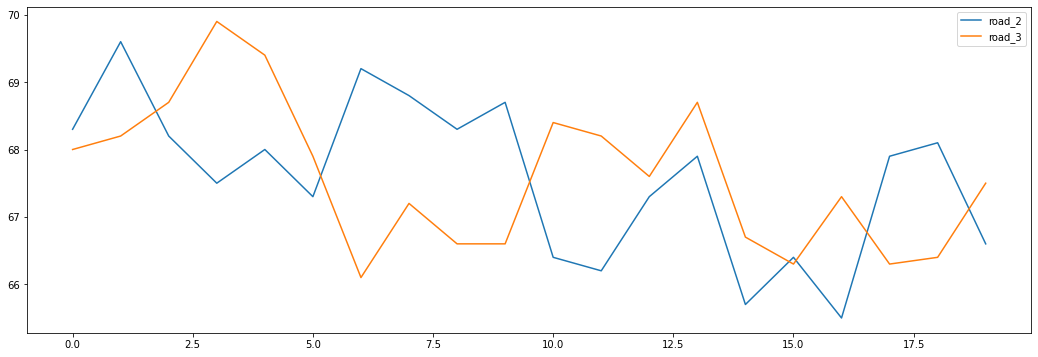

In [9]:
plt.figure(figsize=(18, 6))
plt.plot(velocity_data[:, [1, 2]])
plt.legend(["road_2", "road_3"])

Furthermore, we can visualize the correlation between the time series data from different routes.

Figure 2: Correlation Matrix of Traffic Speed Time Series for Different Routes

In Figure 2, we present a correlation matrix that depicts the relationships between the time series data of traffic speed for various routes. Each cell in the matrix represents the correlation coefficient, which quantifies the strength and direction of the linear relationship between two routes' time series.

The matrix allows us to identify patterns of correlation among the routes. A high positive correlation coefficient suggests a strong positive linear relationship, indicating similar traffic speed trends between the respective routes. On the other hand, a negative correlation coefficient indicates an inverse relationship, suggesting that the traffic speeds of the routes move in opposite directions.

By visualizing the correlation matrix, we can gain insights into the interdependencies and interactions between different routes in terms of traffic speed. This analysis provides valuable information for understanding traffic flow patterns across the road network and can assist in predicting traffic conditions based on the behavior of correlated routes.

Text(0, 0.5, 'route code')

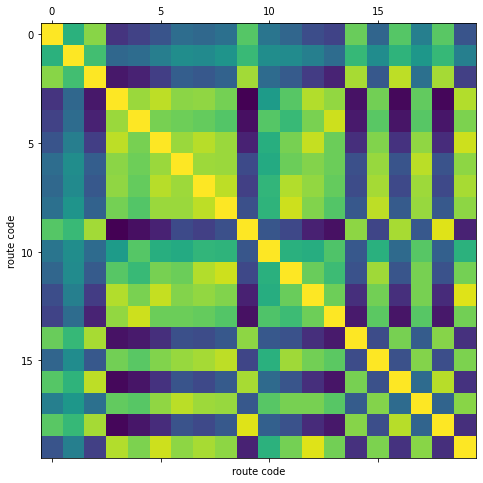

In [5]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(velocity_data.T), 0)
plt.xlabel("route code")
plt.ylabel("route code")

### 3.4 |  Data Splitting and Normalization

Subsequently, we partition the speed values array into three subsets: training_data, validation_data, and testing_data. Additionally, we perform normalization on the resulting arrays. 

The purpose of data splitting is to create separate sets that facilitate model training, validation, and evaluation. The training_data subset is utilized to train the model, the validation_data subset assists in tuning model hyperparameters, and the testing_data subset is employed to assess the final model's performance on unseen data.

Normalization is a preprocessing step applied to the data to ensure that all features are on a similar scale. It aids in preventing certain features from dominating the learning process due to their larger magnitudes. Common normalization techniques include min-max scaling or standardization.

By splitting the data and normalizing it, we establish a robust foundation for subsequent modeling and analysis, promoting accurate and effective predictions of traffic speed.

In [6]:
# Code by [ Arash Khodadadi]
# Source: [https://keras.io/examples/timeseries/timeseries_traffic_forecasting/]
training_fraction, validation_fraction = 0.6, 0.2

def prepare_and_normalize_data(data: np.ndarray, training_fraction: float, validation_fraction: float):

    num_time_steps = data.shape[0]
    num_training, num_validation = (
        int(num_time_steps * training_fraction),
        int(num_time_steps * validation_fraction),
    )
    
    
    training_data = data[:num_training]
    mean, std = training_data.mean(axis=0), training_data.std(axis=0)

    training_data = (training_data - mean) / std
    validation_data = (data[num_training : (num_training + num_validation)] - mean) / std
    testing_data = (data[(num_training + num_validation) :] - mean) / std

    return training_data, validation_data, testing_data


training_data, validation_data, testing_data = prepare_and_normalize_data(velocity_data, training_fraction, validation_fraction)

print(f"Size of the training dataset : {training_data.shape}")
print(f"Size of the Validation dataset : {validation_data.shape}")
print(f"Size of the Testing dataset: {testing_data.shape}")


Size of the training dataset : (5356, 20)
Size of the Validation dataset : (1785, 20)
Size of the Testing dataset: (1787, 20)


### 3.6 | Creating TensorFlow Datasets

The goal of our prediction task is to estimate upcoming road speed values for time periods t+T+1 through t+T+h. This estimation leverages a series of previously observed road speed values from moments t+1, t+2, ... up to t+T.

For each time period t, the input data for our model encompasses T vectors, each spanning a length of N. In this context, N signifies the count of roads within the grid. As a result, the model's input shape stands at T x N.

The predicted output from the model, or the desired outcome, is made up of h vectors, each with a length of N. These vectors depict the forecasted road speed values for the upcoming moments t+T+1 through t+T+h.

To prepare datasets fitting our predictive requirement, we make use of the Keras intrinsic function `timeseries_dataset_from_array()`. At each interval t, our model's input is structured with T vectors, each carrying a dimension of N, denoting the total roads. The model then projects an output of h vectors, each of a dimension N, pertaining to the intervals t+T+1 through t+T+h.

In the given `generate_tf_dataset()`  function, we define `sequence_length`  as T and `prediction_horizon` as h. An interesting parameter here is  `multi_horizon` which warrants further elucidation. When we have `prediction_horizon=3` and `multi_horizon=True`, the model crafts forecasts for intervals t+T+1, t+T+2, and t+T+3. Hence, the resulting shape of the target tensor becomes (T, 3). On the other hand, with `multi_horizon=False`, the model exclusively predicts the speed for the interval t+T+3, resulting in a target tensor shaped (T, 1).

Of significance is the observation that each batch's input tensor is shaped as (batch_size, sequence_length, num_routes, 1). This extra dimension is incorporated to amplify the model's adaptability, permitting the inclusion of diverse time series attributes for each road during every interval. For example, alongside historical speed data, one might integrate temperature time series as input traits. Yet, in this specific scenario, the last dimension of the input tensor remains a constant 1.


In [7]:
# Based on Arash Khodadadi's GNN + LSTM framework
# Original code source: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
sequence_length = 12
prediction_horizon = 3
multiple_horizon = False

def generate_tf_dataset(
    data: np.ndarray,
    sequence_length: int,
    prediction_horizon: int,
    batch_size: int = 128,
    shuffle=False,
    multiple_horizon=True,
):

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data[:-prediction_horizon], axis=-1),
        None,
        sequence_length=sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        sequence_length
        if multiple_horizon
        else sequence_length + prediction_horizon - 1
    )
    target_seq_length = prediction_horizon if multiple_horizon else 1
    targets = timeseries_dataset_from_array(
        data[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


training_dataset, validation_dataset = (
    generate_tf_dataset(data, sequence_length, prediction_horizon, batch_size)
    for data in [training_data, validation_data]
)

testing_dataset = generate_tf_dataset(
    testing_data,
    sequence_length,
    prediction_horizon,
    batch_size=testing_data.shape[0]
)



### 3.7 Roads Graph

As previously stated, we consider the road segments to be nodes of a graph. The distances between the nodes are provided in road_data.csv, and we use these distances to create the graph's adjacency matrix.

In [8]:
# Based on Arash Khodadadi's GNN + LSTM framework
# Original code source: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/
def calculate_adjacency_matrix(
    distance_matrix: np.ndarray, gaussian_sigma: float, threshold: float
):
    
    num_routes = road_data.shape[0]
    distance_matrix = road_data / 10000.0
    squared_weights, weight_mask = (
        distance_matrix * distance_matrix,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-squared_weights / gaussian_sigma) >= threshold) * weight_mask



The function `compute_adjacency_matrix()` returns a boolean adjacency matrix where the value 1 indicates the presence of an edge between two nodes. To store the information about the graph, we employ the following class.

In [9]:
# Based on Arash Khodadadi's GNN + LSTM framework
# Original code source: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/
class GraphDetails:
    def __init__(self, connections: typing.Tuple[list, list], total_nodes: int):
        self.connections = connections
        self.total_nodes = total_nodes


gaussian_sigma = 0.1
threshold = 0.5
adjacency_matrix = calculate_adjacency_matrix(road_data, gaussian_sigma, threshold)
node_ids, neighbor_ids = np.where(adjacency_matrix == 1)
graph = GraphDetails(
    connections=(node_ids.tolist(), neighbor_ids.tolist()),
    total_nodes=adjacency_matrix.shape[0],
)
print(f"The total number of graph nodes: {graph.total_nodes}, The total number of graph edges: {len(graph.connections[0])}")


The total number of graph nodes: 20, The total number of graph edges: 84


In [10]:
print(adjacency_matrix)

[[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.

## 4.0 | Model Built 

This paper uses two models, lstm and lstm+gcn, to predict traffic flow in Xi'an

### 4.1 LSTM Model Built
Long Short-Term Memory (LSTM) is a specialized form of recurrent neural networks capable of grasping and preserving knowledge across extended sequences. When it comes to predicting traffic flow, we view the speed of each roadway segment as a time series, harnessing LSTM to handle this sequential data. In essence, we use historical traffic speed data as input to cultivate an LSTM model, preparing it to forecast upcoming traffic velocities.

The LSTM model we adopt in this research consists of an entry layer, an LSTM segment, and a concluding layer. The entry layer is designed to accommodate input sequences, the LSTM segment aims to detect temporal relationships and safeguard enduring insights, and the concluding layer is tasked with producing forecasts grounded in discerned patterns.

For the model's training phase, we turn to the mean squared error to serve as the loss function, which gauges the variance between forecasted and genuine traffic speeds. The Adam optimization technique is harnessed to fine-tune the model's parameters throughout the training, targeting loss reduction and boosting the model's forecasting accuracy.

In [11]:
# Based on Arash Khodadadi's GNN + LSTM framework
# Original code source: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

class LSTM(layers.Layer):
    """Layer consisting of LSTM and fully connected layers."""

    def __init__(
        self,
        input_features,
        output_features,
        lstm_units: int,
        input_sequence_length: int,
        output_sequence_length: int,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.lstm_layer = layers.LSTM(lstm_units, activation="relu")
        self.fully_connected_layer = layers.Dense(output_sequence_length)

        self.input_sequence_length, self.output_sequence_length = input_sequence_length, output_sequence_length

    def call(self, input_data):
        

        # Convert shape to  (num_nodes, batch_size, input_sequence_length, input_features)
        input_data = tf.transpose(input_data, [2, 0, 1, 3])

        shape = tf.shape(input_data)
        num_nodes, batch_size, input_sequence_length, input_features = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM only accepts 3D tensors as input
        lstm_input = tf.reshape(input_data, (batch_size * num_nodes, input_sequence_length, input_features))
        lstm_output = self.lstm_layer(lstm_input)

        fully_connected_output = self.fully_connected_layer(lstm_output)
        final_output = tf.reshape(fully_connected_output, (num_nodes, batch_size, self.output_sequence_length))
        return tf.transpose(final_output, [1, 2, 0])


### 4.2 LSTM + GCN Model Built
For a comprehensive understanding of both time-related and spatial dynamics, we amalgamate graph convolutional networks (GCNs) with LSTMs. We start by mapping the traffic system as a graph, where nodes signify road stretches, and edges denote interconnections between them. Next, we deploy GCNs to analyze traffic velocity data on this graph, ensuring the discernment of spatial interrelationships among road sections.

The result produced by the GCN component is then channeled into an LSTM segment adept at deciphering time-based relations in the dataset. By integrating this LSTM segment, we duly address the sequential character of the traffic velocity chronicles. As a result, the LSTM component grasps trends and enduring associations spanning numerous time intervals.

Subsequently, the outcome of the LSTM segment is directed to a densely connected layer, designated as the final prognostication layer to project upcoming traffic velocities. This dense layer formulates future estimations leveraging insights acquired from both the GCN and LSTM segments.

During the model's refinement phase, we enlist the mean squared error as our loss metric, measuring the divergence between the forecasted and factual traffic velocities. The Adam optimization method is engaged to refine the model's attributes, ensuring streamlined progression throughout the learning phase.

#### 4.2.1 ｜ Graph convolution layer

Our version of the graph convolution layer anticipates a 4D tensor structure for input, characterized by dimensions (num_nodes, batch_size, input_seq_length, in_feat). The operational procedure of this layer encompasses the subsequent phases:

1. Computing Node Representations:
   - The input features are multiplied by the weight matrix to calculate the node representations. This computation is performed using the self.compute_node_features() function.

2. Computing Aggregated Messages:
   - The layer proceeds to compute the aggregated messages of the neighboring nodes. This step involves aggregating the representations of neighboring nodes and then multiplying the resulting values with the weight matrix. The self.compute_aggregated_messages() function handles this computation.

3. Updating Node Representations:
   - In the final step, self.update(), the layer combines the node representations with the aggregated messages from the neighbors to generate the final output. The specific mechanism for combining the representations and messages depends on the design of the layer.

These steps collectively enable the graph convolution layer to process the input data and generate meaningful representations by incorporating information from both the input features and the connections between nodes.

In [12]:
# Based on Arash Khodadadi's GNN + LSTM framework
# Original code source: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/
class GraphConvolutionLayer(layers.Layer):
    def __init__(
        self,
        input_features,
        output_features,
        graph_details: GraphDetails,
        aggregation_method="mean",
        combination_method="concat",
        activation_function: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.graph_details = graph_details
        self.aggregation_method = aggregation_method
        self.combination_method = combination_method
        self.graph_conv_weights = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(input_features, output_features), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation_function)

    def aggregate(self, neighbor_features: tf.Tensor):
        aggregation_function = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_method)

        if aggregation_function:
            return aggregation_function(
                neighbor_features,
                self.graph_details.connections[0],
                num_segments=self.graph_details.total_nodes,
            )

        raise ValueError(f"Invalid aggregation method: {self.aggregation_method}")

    def compute_node_features(self, features: tf.Tensor):
        """Computes each node's features.

        Node attributes are obtained by executing element-wise multiplication between the input attributes tensor and `self.weights`. It's pivotal to emphasize that the configuration of `self.weights` is `(input_features, output_features)`.

        Parameters:
        features: A tensor structured as `(num_nodes, batch_size, input_seq_len, input_features)`.

        Returns:
        A tensor formatted as `(num_nodes, batch_size, input_seq_len, output_features)`.

        """
        return tf.matmul(features, self.graph_conv_weights)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbor_features = tf.gather(features, self.graph_details.connections[1])
        aggregated_messages = self.aggregate(neighbor_features)
        return tf.matmul(aggregated_messages, self.graph_conv_weights)

    def update(self, node_features: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_method == "concat":
            h = tf.concat([node_features, aggregated_messages], axis=-1)
        elif self.combination_method == "add":
            h = node_features + aggregated_messages
        else:
            raise ValueError(f"Invalid combination method: {self.combination_method}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
    
        node_features = self.compute_node_features(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(node_features, aggregated_messages)


#### 4.2.2 ｜ LSTM plus graph convolution

Following the application of the graph convolution layer on the input tensor, the emerging 4D tensor holds depictions of the nodes across timeframes. The depiction of each node is shaped by insights from its adjacent nodes, allowing the assimilation of spatial connections inherent in the graph's design.

To delve deeper into the time-related insights embedded within these node depictions, we deploy a recurrent segment, more specifically an LSTM layer, to handle the tensor corresponding to each node. The fusion of the graph convolution layer with the LSTM results in the GraphConvLSTM layer. This confluence harmonizes both spatial and chronological data for a more profound evaluation and projection.

Subsequent to the GraphConvLSTM layer's output, it's directed to a densely connected segment, tasked as the terminal forecasting layer. This segment refines the unearthed depictions to produce the conclusive estimations pertinent to the prediction endeavor.

Through the amalgamation of the graph convolution layer, LSTM segment, and the densely connected layer, our architecture is poised to adeptly grasp both the spatial and chronological ties in the dataset, endorsing precise anticipations of impending traffic velocities.

In [13]:
# Based on Arash Khodadadi's GNN + LSTM framework
# Original code source: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/
class GraphConvLSTM(layers.Layer):
    """Layer consisting of a graph convolution layer followed by LSTM and fully connected layers."""

    def __init__(
        self,
        input_features,
        output_features,
        lstm_units: int,
        input_sequence_length: int,
        output_sequence_length: int,
        graph_data: GraphDetails,
        graph_convolution_parameters: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # Graph convolution layer
        if graph_convolution_parameters is None:
            graph_convolution_parameters = {
                "aggregation_method": "mean",
                "combination_method": "concat",
                "activation_function": None,
            }
        self.graph_convolution = GraphConvolutionLayer(input_features, output_features, graph_data, **graph_convolution_parameters)

        self.lstm_layer = layers.LSTM(lstm_units, activation="relu")
        self.fully_connected_layer = layers.Dense(output_sequence_length)

        self.input_sequence_length, self.output_sequence_length = input_sequence_length, output_sequence_length

    def call(self, input_data):

        # Convert shape to  (num_nodes, batch_size, input_sequence_length, input_features)
        input_data = tf.transpose(input_data, [2, 0, 1, 3])

        graph_convolution_output = self.graph_convolution(input_data)
        shape = tf.shape(graph_convolution_output)
        num_nodes, batch_size, input_sequence_length, output_features = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM models typically require 3D tensors as input, 
        #where the dimensions represent the batch size, sequence length, and input features, respectively. Therefore, before feeding the data into the LSTM layer, 
        #we need to reshape the input tensor from a 4D tensor to a 3D tensor.
        graph_convolution_output = tf.reshape(graph_convolution_output, (batch_size * num_nodes, input_sequence_length, output_features))
        lstm_output = self.lstm_layer(graph_convolution_output)

        fully_connected_output = self.fully_connected_layer(lstm_output)
        output = tf.reshape(fully_connected_output, (num_nodes, batch_size, self.output_sequence_length))
        return tf.transpose(output, [1, 2, 0])


## 5. 0 ｜ Model training

### 5.1 LSTM Model Training 

In [18]:
# Based on Arash Khodadadi's GNN + LSTM framework
# Original code source: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/
input_features = 1
batch_size = 64
training_epochs = 20
input_seq_len = 12
prediction_horizon = 3
multi_horizon_prediction = False
output_features = 10
lstm_units_count = 64


lstm_model = LSTM(
    input_features,
    output_features,
    lstm_units_count,
    input_seq_len,
    prediction_horizon
    
)
model_inputs = layers.Input((input_seq_len, training_epochs, input_features))
model_outputs = lstm_model(model_inputs)

lstm_model = keras.models.Model(model_inputs, model_outputs)
lstm_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
lstm_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=training_epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)


Epoch 1/20
84/84 [==============================] - 8s 76ms/step - loss: 0.8153 - val_loss: 0.7626
Epoch 2/20
84/84 [==============================] - 6s 70ms/step - loss: 0.5004 - val_loss: 0.4530
Epoch 3/20
84/84 [==============================] - 7s 81ms/step - loss: 0.3427 - val_loss: 0.2786
Epoch 4/20
84/84 [==============================] - 8s 91ms/step - loss: 0.2341 - val_loss: 0.1695
Epoch 5/20
84/84 [==============================] - 8s 94ms/step - loss: 0.1936 - val_loss: 0.1506
Epoch 6/20
84/84 [==============================] - 7s 88ms/step - loss: 0.1767 - val_loss: 0.1382
Epoch 7/20
84/84 [==============================] - 6s 70ms/step - loss: 0.1634 - val_loss: 0.1275
Epoch 8/20
84/84 [==============================] - 6s 69ms/step - loss: 0.1520 - val_loss: 0.1184
Epoch 9/20
84/84 [==============================] - 7s 82ms/step - loss: 0.1419 - val_loss: 0.1104
Epoch 10/20
84/84 [==============================] - 8s 94ms/step - loss: 0.1326 - val_loss: 0.1031
Epoch 11/

### 5.2 LSTM + GCN Model Training 

In [16]:
input_features = 1
batch_size = 64
training_epochs = 20
input_seq_len = 12
prediction_horizon = 3
multi_horizon_prediction = False
output_features = 10
lstm_units_count = 64
graph_convolution_parameters = {
    "aggregation_method": "mean",
    "combination_method": "concat",
    "activation_function": None,
}

graph_conv_lstm_model = GraphConvLSTM(
    input_features,
    output_features,
    lstm_units_count,
    input_seq_len,
    prediction_horizon,
    graph,
    graph_convolution_parameters,
)
model_inputs = layers.Input((input_seq_len, graph.total_nodes, input_features))
model_outputs = graph_conv_lstm_model(model_inputs)

lst_gcn_model = keras.models.Model(model_inputs, model_outputs)
lst_gcn_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
lst_gcn_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=training_epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)


Epoch 1/20


2023-06-24 07:11:12.872561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_25' with dtype double and shape [5344,20]
	 [[{{node Placeholder/_25}}]]
2023-06-24 07:11:12.873834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [5342]
	 [[{{node Placeholder/_8}}]]


83/84 [============================>.] - ETA: 0s - loss: 0.5549

2023-06-24 07:11:20.965062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_38' with dtype int32
	 [[{{node Placeholder/_38}}]]
2023-06-24 07:11:20.966429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_25' with dtype double and shape [1773,20]
	 [[{{node Placeholder/_25}}]]


84/84 [==============================] - 9s 90ms/step - loss: 0.5529 - val_loss: 0.2492
Epoch 2/20
84/84 [==============================] - 7s 84ms/step - loss: 0.2238 - val_loss: 0.1579
Epoch 3/20
84/84 [==============================] - 7s 86ms/step - loss: 0.1615 - val_loss: 0.1239
Epoch 4/20
84/84 [==============================] - 8s 97ms/step - loss: 0.1352 - val_loss: 0.1063
Epoch 5/20
84/84 [==============================] - 8s 98ms/step - loss: 0.1205 - val_loss: 0.0958
Epoch 6/20
84/84 [==============================] - 10s 117ms/step - loss: 0.1108 - val_loss: 0.0885
Epoch 7/20
84/84 [==============================] - 10s 119ms/step - loss: 0.1045 - val_loss: 0.0878
Epoch 8/20
84/84 [==============================] - 10s 121ms/step - loss: 0.1017 - val_loss: 0.0873
Epoch 9/20
84/84 [==============================] - 11s 127ms/step - loss: 0.1001 - val_loss: 0.0860
Epoch 10/20
84/84 [==============================] - 7s 80ms/step - loss: 0.0988 - val_loss: 0.0847
Epoch 11/20


## 6.0 Making forecasts on test set

Once the LSTM and LSTM+GCN models have been trained, we can proceed to utilize these trained models to generate forecasts on the test dataset. Subsequently, we calculate the mean absolute error (MAE) of the forecasts produced by each model and compare them to the MAE of the naive forecasts. The naive forecasts are obtained by using the most recent known speed value for each node as the prediction.

For the LSTM model, we employ the trained model to make predictions on the test set. These predictions are then compared to the corresponding true values from the test set, and the MAE is computed as the average absolute difference between the predicted and true values across all nodes.

Similarly, for the LSTM+GCN model, the trained model is used to generate forecasts on the test set. The MAE is calculated by comparing these forecasts with the true values from the test set.

By comparing the MAE of each model with that of the naive forecasts, we can assess the predictive performance and effectiveness of the LSTM and LSTM+GCN models in capturing the traffic flow patterns.

### 6.1  LSTM model predictions

2023-06-24 07:19:11.695333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype int32 and shape [1773]
	 [[{{node Placeholder/_33}}]]
2023-06-24 07:19:11.697128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


1/1 [==============================] - 1s 1s/step
LSTM model: Naive Mean Squared Error: 0.04171463116520283
LSTM model: Model Mean Squared Error: 0.04285515302145748
LSTM  model: Root Mean Square Error: 0.20701486183715767
LSTM  model: Mean Absolute Error: 0.12981301773761142


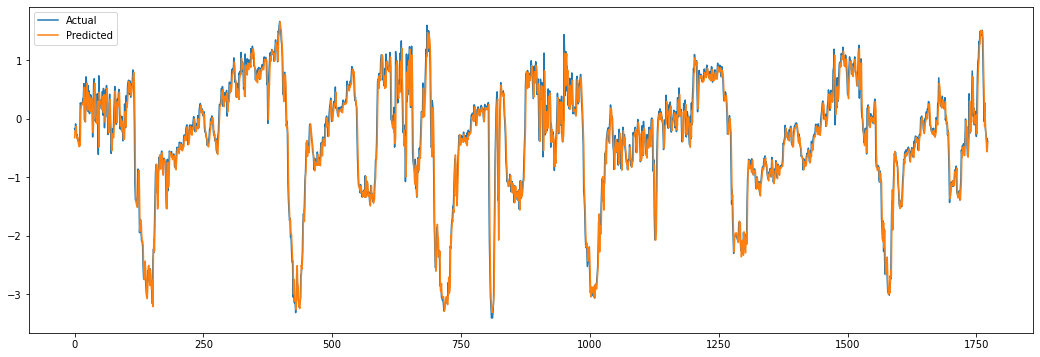

In [19]:
lstm_test_data, lstm_actual_values = next(testing_dataset.as_numpy_iterator())
lstm_predicted_values = lstm_model.predict(testing_dataset)
plt.figure(figsize=(18, 6))
plt.plot(lstm_actual_values[:, 0, 0])
plt.plot(lstm_predicted_values[:, 0, 0])
plt.legend(["Actual", "Predicted"])

# RMSE
rmse = np.sqrt(np.mean(np.square(lstm_predicted_values[:, 0, :] - lstm_actual_values[:, 0, :])))

# MAE
mae = np.mean(np.abs(lstm_predicted_values[:, 0, :] - lstm_actual_values[:, 0, :]))

naive_mean_squared_error, model_mean_squared_error = (
    np.square(lstm_test_data[:, -1, :, 0] - lstm_actual_values[:, 0, :]).mean(),
    np.square(lstm_predicted_values[:, 0, :] - lstm_actual_values[:, 0, :]).mean(),
)
print(f"LSTM model: Naive Mean Squared Error: {naive_mean_squared_error}")
print(f"LSTM model: Model Mean Squared Error: {model_mean_squared_error}")
print(f"LSTM  model: Root Mean Square Error: {rmse}")
print(f"LSTM  model: Mean Absolute Error: {mae}")


### 6.2  LSTM + GCN model predictions

1/1 [==============================] - 1s 1s/step
LSTM + GCN model: Naive Mean Squared Error: 0.04171463116520283
LSTM + GCN model: Model Mean Squared Error: 0.03895440098581372
LSTM + GCN model: Root Mean Square Error: 0.19736869302352317
LSTM + GCN model: Mean Absolute Error: 0.12383537478463391


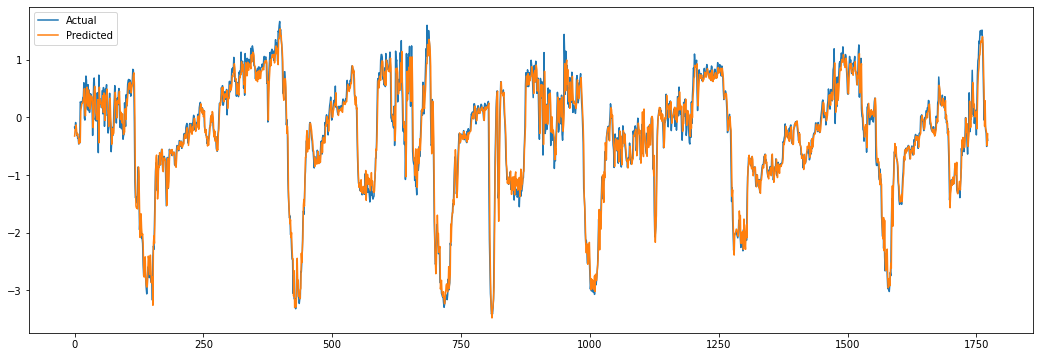

In [20]:
test_data, actual_values = next(testing_dataset.as_numpy_iterator())
predicted_values = lst_gcn_model.predict(testing_dataset)
plt.figure(figsize=(18, 6))
plt.plot(actual_values[:, 0, 0])
plt.plot(predicted_values[:, 0, 0])
plt.legend(["Actual", "Predicted"])

naive_mean_squared_error, model_mean_squared_error = (
    np.square(test_data[:, -1, :, 0] - actual_values[:, 0, :]).mean(),
    np.square(predicted_values[:, 0, :] - actual_values[:, 0, :]).mean(),
)
# RMSE
rmse = np.sqrt(np.mean(np.square(predicted_values[:, 0, :] - actual_values[:, 0, :])))

# MAE
mae = np.mean(np.abs(predicted_values[:, 0, :] - actual_values[:, 0, :]))


print(f"LSTM + GCN model: Naive Mean Squared Error: {naive_mean_squared_error}")
print(f"LSTM + GCN model: Model Mean Squared Error: {model_mean_squared_error}")
print(f"LSTM + GCN model: Root Mean Square Error: {rmse}")
print(f"LSTM + GCN model: Mean Absolute Error: {mae}")



In [252]:
test_data.shape

(1773, 12, 20, 1)

## 7.0 ｜Results and Discussion
During the training phase for the two models, we use a dataset segmented into several training batches. The entire training procedure encompasses 84 cycles, with every batch comprising 64 instances. For the refinement of the model's attributes, the Adam optimizer is engaged, operating with a learning rate set at 0.0002.


### 7.1 When training these two models, two metrics are evaluated: the loss function (loss) and the validation loss function (val_loss).
During the training of a neural network model, it's standard practice to keep an eye on two main metrics: the loss function (loss) and the validation loss function (val_loss).

The loss function (loss) evaluates the efficacy of the model on the training data, determining the deviation between the model's forecasts and the actual values for each training batch. The aim throughout training is to diminish this loss, thereby boosting the model's proficiency in delivering precise forecasts.

The validation loss function (val_loss) assesses the model's performance on a separate validation set that comprises data not encountered during training. It serves as a measure of the model's generalization capability to unseen data and aids in mitigating overfitting. Lower values of the validation loss function indicate superior performance of the model on previously unseen data.

Comparing the LSTM and LSTM+GCN models, after 20 training iterations, the respective index values are as follows:

LSTM model: loss of 0.1086 and val_loss of 0.0865 

LSTM+GCN combined model: loss of 0.0938 and val_loss of 0.0803.

These metrics provide insights into the models' performance on the training and validation datasets.

Numerically, the combined LSTM+GCN model indicates marginally reduced loss values when contrasted with the LSTM model for both the training and validation datasets. This implies that, post 20 training cycles, the LSTM+GCN model adjusts more adeptly to the training dataset and offers enhanced accuracy in predicting the target outcomes on the validation set, outpacing the LSTM model's performance.

### 7.2 Comparing the performance of lstm model and lstm+gcn model
After training the LSTM and LSTM+GCN models, we proceed to generate forecasts on the testing dataset using these refined models. We then compute the Mean Square Error (MSE), Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and MSE for naive predictions for each model. These naive predictions are obtained by taking the latest known speed value for each node as the projected value. Evaluating these four indicators allows us to assess the relative efficiency of both models in forecasting traffic dynamics.

The outcomes present the efficacy of the two models, LSTM and LSTM+GCN, in predicting traffic movement trends. Analyzing these indicators, we infer the following insights:

- In terms of Mean Squared Error (MSE), the LSTM+GCN model (0.0390) outperforms the LSTM model (0.0429), indicating that the LSTM+GCN model has a smaller error in predicting traffic flow.

- For Root Mean Square Error (RMSE), the LSTM+GCN model (0.1974) also performs better than the LSTM model (0.2070). RMSE is the square root of MSE, and it reflects the average prediction error of the model more accurately.

- Regarding Mean Absolute Error (MAE), the LSTM+GCN model (0.1238) again surpasses the LSTM model (0.1298). MAE quantifies the average absolute deviation between the forecasted and the true values.

In essence, the LSTM+GCN model surpasses the LSTM model in every performance measure, suggesting that the integration of the LSTM with the Graph Convolutional Network offers enhanced results in predicting traffic flow than the sole LSTM model. This advantage likely stems from the LSTM+GCN model's ability to capture both time-based and spatial patterns in the traffic network, whereas the LSTM model predominantly focuses on temporal sequences.

## 8.0 ｜Conclusion
This research set out to juxtapose the LSTM model against the LSTM+GCN model in the domain of traffic flow forecasting, with a central focus on gauging their predictive prowess.

To assess their effectiveness, we employed a trio of metrics: Mean Square Error (MSE), Mean Absolute Error (MAE), and Root Mean Square Error (RMSE). The findings consistently showcased the LSTM+GCN model's superiority over its LSTM counterpart in forecasting traffic flow. This superior performance is likely due to the LSTM+GCN model's capability to simultaneously account for both time-based and spatial interconnections within the traffic framework, emphasizing the interrelation among various road sections. Meanwhile, the LSTM model primarily hones in on time-sequence patterns.

Looking ahead, there's potential in delving deeper into intricate traffic situations, integrating elements like meteorological variables and on-road incidents. Such inclusions might augment the predictive accuracy of both models. Furthermore, evaluating how the LSTM and LSTM+GCN models fare in predicting traffic flow amidst these enriched contexts promises to be an intriguing exploration.

In summary, this research offers a comparative lens on the efficiency of LSTM and LSTM+GCN models in the realm of traffic flow prediction, underscoring the benefits of meshing spatial relations via graph convolutional networks with LSTM methodologies.

## 9.0 ｜Reference


B. M. Williams. 2001. Multivariate vehicular traffic flow prediction—Evaluation of ARIMAX modeling. Transportation Research Record, no. 1776, pp. 194-200.

Chen, Q., Song, X., Yamada, H., & Shibasaki, R. 2016. Learning deep representation from big and heterogeneous data for traffic accident inference. In AAAI, pp. 338-344.

Defferrard, M., Bresson, X., & Vandergheynst, P. 2016 . Convolutional neural networks on graphs with fast localized spectral filtering. In NIPS, pp. 3844-3852.

Huang. W, Song. G, Hong. H,  Xie, K. 2014. Deep architecture for traffic flow prediction: deep belief networks with multitask learning. IEEE Transactions on Intelligent Transportation Systems, 15(5), 2191-2201.

Jia. Y, Wu. J and Du. Y. 2016. Traffic speed prediction using deep learning method. In ITSC,pp. 1217-1222

Lv, Y., Duan, Y., Kang, W., Li, Z., & Wang, F.-Y. 2015. Traffic flow prediction with big data: a deep learning approach. IEEE Transactions on Intelligent Transportation Systems, 16(2). 865-873.

M. Hamed, H. Al-Masaeid and Z. Said. 1995. Short-term prediction of traffic volume in urban arterials. Journal of Transportation Engineering, vol. 121, no. 3, pp. 249-254.

M. Levin and Y.-D. Tsao. 1980. On forecasting freeway occupancies and volumes. Transportation Research Record, no. 773, pp. 47-49.

M. S. Ahmed and A. R. Cook. 1979. Analysis of freeway traffic time-series data by using Box–Jenkins techniques. Transportation Research Record, no. 722, pp. 1-9.

M. vanderVoort, M. Dougherty and S. Watson. 1996. Combining Kohonen maps with ARIMA time series models to forecast traffic flow. Transportation Research Part C: Emerging Technologies, vol. 4, no. 5, pp. 307-318.

N. Zhang, F.-Y. Wang, F. Zhu, D. Zhao and S. Tang. 2008. DynaCAS: Computational experiments and decision support for ITS. IEEE Intelligent Systems, vol. 23, no. 6, pp. 19-23, Nov./Dec.

S. Lee and D. Fambro. 1999. Application of subset autoregressive integrated moving average model for short-term freeway traffic volume forecasting. Transportation Research Record, vol. 1678, pp. 179-188.

Y. Kamarianakis and P. Prastacos. 2003. Forecasting traffic flow conditions in an urban network—Comparison of multivariate and univariate approaches. Transportation Research Record, no. 1857, pp. 74-84.

